In [6]:
import pandas as pd
import experiment.preprocess as preprocess
from candidates_generation import triple_gen
import importlib
import numpy as np

In [7]:
path ='data/codex-m/data_sample.csv'
df = pd.read_csv(path)
evaluation_df, candidates_df, missing_df = preprocess.create_experiment_df(path)

/Users/fieng/Project/KGC_RAG/experiment/preprocess.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_cand_df['Missing'] = 1
/Users/fieng/Project/KGC_RAG/experiment/preprocess.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_cand_df['Missing'] = 0


In [8]:
import experiment.filtering as filtering

filtred_df = filtering.create_filtred_df(df, evaluation_df, missing_df)

/Users/fieng/Project/KGC_RAG/langchain-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: fieng. Use `wandb login --relogin` to force relogin


No cuda devices were available. The model runs on CPU
Training epochs on cpu: 100%|██████████| 50/50 [01:23<00:00,  1.67s/epoch, loss=0.456, prev_loss=0.457]
Evaluating on cpu:   0%|          | 0.00/50.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 50.0/50.0 [00:00<00:00, 135triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.52s seconds


loss,█▄▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
testing.both.optimistic.adjusted_arithmetic_mean_rank,▁
testing.both.optimistic.adjusted_arithmetic_mean_rank_index,▁
testing.both.optimistic.adjusted_geometric_mean_rank_index,▁
testing.both.optimistic.adjusted_hits_at_k,▁
testing.both.optimistic.adjusted_inverse_harmonic_mean_rank,▁
testing.both.optimistic.arithmetic_mean_rank,▁
testing.both.optimistic.count,▁
testing.both.optimistic.geometric_mean_rank,▁
testing.both.optimistic.harmonic_mean_rank,▁
testing.both.optimistic.hits_at_1,▁


In [9]:
filtred_df = filtred_df.merge(evaluation_df, how='left')

In [10]:
true_cand_df = filtred_df[filtred_df['Missing'] == 1].sample(250)
false_cand_df = filtred_df[filtred_df['Missing'] == 0].sample(250)

In [11]:
filtred_df_sample = pd.concat([true_cand_df, false_cand_df])
filtred_df_sample = filtred_df_sample.sample(frac=1)

In [12]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from langchain_experimental.text_splitter import SemanticChunker
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS


In [13]:
loader = CSVLoader(file_path=path)
docs = loader.load()
text_splitter = SemanticChunker(HuggingFaceEmbeddings())
documents = text_splitter.split_documents(docs)
# Instantiate the embedding model
embedder = HuggingFaceEmbeddings()
# Create the vector store 
vector = FAISS.from_documents(documents, embedder)

/var/folders/_3/wtwzgv1d3rlfz233qkf36kg00000gp/T/ipykernel_26661/991692131.py:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  text_splitter = SemanticChunker(HuggingFaceEmbeddings())
/var/folders/_3/wtwzgv1d3rlfz233qkf36kg00000gp/T/ipykernel_26661/991692131.py:3: LangChainDeprecationWarning: Default values for HuggingFaceEmbeddings.model_name were deprecated in LangChain 0.2.16 and will be removed in 0.4.0. Explicitly pass a model_name to the HuggingFaceEmbeddings constructor instead.
  text_splitter = SemanticChunker(HuggingFaceEmbeddings())
/var/folders/_3/wtwzgv1d3rlfz233qkf36kg00000gp/T/ipykernel_26661/991692131.py:6: LangChainDeprecationWarning: D

In [14]:
from langchain_community.llms import Ollama

retriever = vector.as_retriever(search_type="similarity", search_kwargs={"k": 2})
# Define llm
llm = Ollama(model="mistral")

/var/folders/_3/wtwzgv1d3rlfz233qkf36kg00000gp/T/ipykernel_26661/4025605401.py:5: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  llm = Ollama(model="mistral")


In [15]:
from langchain.chains import RetrievalQA
from langchain.chains.llm import LLMChain
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.prompts import PromptTemplate
from langchain_core.prompts import ChatPromptTemplate

In [16]:
def triple2sentence(head,relation,tail):
    template = """Transform the following triples into a sentence: {head} {relation} {tail}

    Answer: Give the sentence."""

    prompt = ChatPromptTemplate.from_template(template)
    model = llm
    chain = prompt | model

    sentence = chain.invoke({"head": head,
                "relation": relation,
                'tail': tail}
                )
   
    return sentence

In [17]:
sentence_list = []
for item in filtred_df_sample.iterrows():
    triple = item[1]
    head = triple['Head']
    relation = triple['Relation']
    tail = triple['Tail']
    sentence = triple2sentence(head,relation,tail)
    sentence_list.append(sentence)

In [18]:
prompt = """
1. Use the following pieces of context to answer the question at the end.\n
2. Is the sentence in question correct: answer "1" if it is correct and "0" otherwise.\n
3. If you don't know the answer, just say that "-1"\n
4. Keep the answer limited to the score.
5. Start the answer with 'Score:'

Context: {context}

Question: {question}

Helpful Answer:"""


QA_CHAIN_PROMPT = PromptTemplate.from_template(prompt) 

llm_chain = LLMChain(
                llm=llm, 
                prompt=QA_CHAIN_PROMPT, 
                callbacks=None, 
                verbose=False)

document_prompt = PromptTemplate(
    input_variables=["page_content", "source"],
    template="Context:\ncontent:{page_content}\nsource:{source}",
)

combine_documents_chain = StuffDocumentsChain(
                llm_chain=llm_chain,
                document_variable_name="context",
                document_prompt=document_prompt,
                callbacks=None,
            )
qa = RetrievalQA(
                combine_documents_chain=combine_documents_chain,
                verbose=False,
                retriever=retriever,
                return_source_documents=False,
            )

/var/folders/_3/wtwzgv1d3rlfz233qkf36kg00000gp/T/ipykernel_26661/419384603.py:17: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  llm_chain = LLMChain(
/var/folders/_3/wtwzgv1d3rlfz233qkf36kg00000gp/T/ipykernel_26661/419384603.py:28: LangChainDeprecationWarning: This class is deprecated. Use the `create_stuff_documents_chain` constructor instead. See migration guide here: https://python.langchain.com/docs/versions/migrating_chains/stuff_docs_chain/
  combine_documents_chain = StuffDocumentsChain(
/var/folders/_3/wtwzgv1d3rlfz233qkf36kg00000gp/T/ipykernel_26661/419384603.py:34: LangChainDeprecationWarning: This class is deprecated. Use the `create_retrieval_chain` constructor instead. See migration guide here: https://python.langchain.com/docs/versions/migrating_chains/retrieval_qa/
  qa = RetrievalQA(


In [19]:
def eval_sentence_list(qa, sentence_list):
    score_list = []
    for sentence in sentence_list:
        score = qa(sentence)["result"]
        score_list.append(score)
    return score_list

In [20]:
sentence_list[:3]

[' "Tunisia and Malaysia enjoy friendly diplomatic relations." or "Diplomatic relations between Tunisia and Malaysia are amicable."',
 ' Hans Blüher is a psychiatrist.',
 ' "Vincent Gallo is a writer."']

In [21]:
score_list = eval_sentence_list(qa, sentence_list)

/var/folders/_3/wtwzgv1d3rlfz233qkf36kg00000gp/T/ipykernel_26661/721255770.py:4: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  score = qa(sentence)["result"]


In [22]:
def clean_score(list_score) -> list[float]:
    list_score = [item.rstrip('.') if item.endswith('.') else item for item in list_score]
    list_score = [0 if item == '' else item for item in list_score]
    score_bin = [1 if item == '1'  else 0 for item in list_score]
    return score_bin


def extract_score(text:str)->str:
    # Function to extract score
    # Find the starting index of "Score: "
    start_index = text.find("Score: ") + len("Score: ")

    # Find the end of the number, which could be marked by a non-digit character
    end_index = start_index
    while end_index < len(text) and (text[end_index].isdigit() or text[end_index] == '.'):
        end_index += 1

    # Extract and return the number using slicing
    return text[start_index:end_index]

In [23]:
new_score_list = [extract_score(score) for score in score_list]
new_score_list = clean_score(new_score_list)

In [24]:
filtred_df_sample['Pred'] = new_score_list

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_score_conf_matrix(pred, ground_truth, title):
    # Generate the confusion matrix
    cm = confusion_matrix(ground_truth, pred)

    # Display the confusion matrix using seaborn heatmap
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Unvalid', 'Pred Valid'], yticklabels=['True Unvalid', 'True Valid'],  vmin=0, vmax=250)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

def compute_score(prediction, ground_truth):
    cm = confusion_matrix(ground_truth, prediction)
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
    accuracy = (TN + TP) / (TN + TP + FN + FP)
    f1_score = (2 * TP) / (2 * TP + FP + FN)
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    return accuracy, f1_score, recall, precision

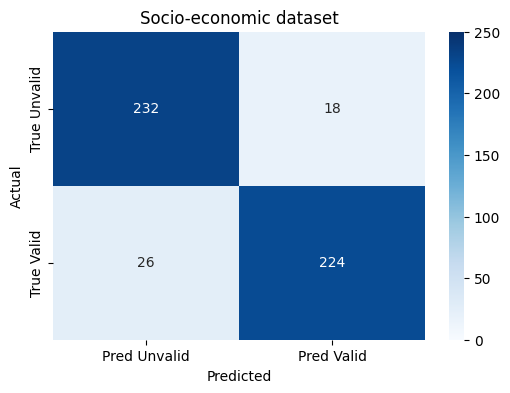

In [26]:
ground_truth = filtred_df_sample['Missing']
prediction = filtred_df_sample['Pred']
title = 'Socio-economic dataset'
plot_score_conf_matrix(prediction, ground_truth, title)

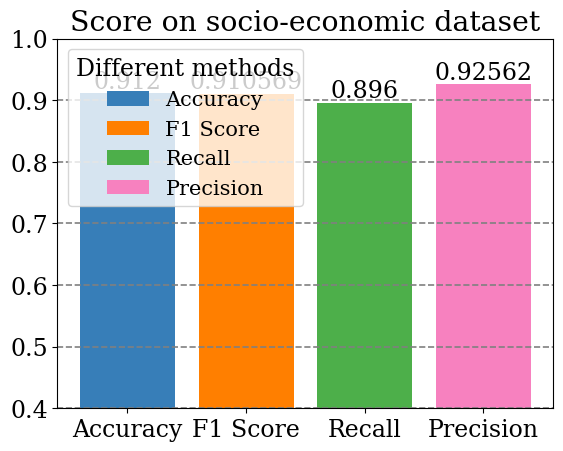

In [27]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np 

ground_truth = filtred_df_sample['Missing']
prediction = filtred_df_sample['Pred']
accuracy, f1_score, recall, precision = compute_score(prediction, ground_truth)
scores = [accuracy, f1_score, recall, precision]
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
labels = ['Accuracy', 'F1 Score', 'Recall', 'Precision']
# setup family font
plt.rc('font', family='serif',size=17)
fig, ax = plt.subplots()
bars = ax.bar(labels, scores , label=labels, color=colors[:4])
# Set y-limit to center data
ax.set_ylim(0.4,1)

# Add legend with title
ax.legend(title='Different methods', fontsize = 15, loc=2)
# Add gridlines (only on the y-axis)
ax.grid(linewidth=1.2, linestyle='--', axis='y', color='grey')
ax.set_title('Score on socio-economic dataset')
ax.bar_label(bars)
plt.savefig('results/socio_economic.png')

In [28]:
import llm_eval.eval
from llm_eval.eval import eval_df, eval_df_context

def clean_score_llm(list_score, thresh) -> list[float]:
    list_score = [item.rstrip('.') if item.endswith('.') else item for item in list_score]
    #list_score = [item for item in list_score if item and item.strip()]
    list_score = [0 if item == '' else item for item in list_score]
    score_bin = [1 if float(item) > thresh else 0 for item in list_score]
    return score_bin

score_cand = eval_df(filtred_df_sample, 500)
score_cand_cont = eval_df_context(filtred_df_sample, 500)


100/500
200/500
300/500
400/500
500/500
Finished

100/500
200/500
300/500
400/500
500/500
Finished



In [29]:
def clean_score_llm(list_score, thresh) -> list[float]:
    list_score = [item.rstrip('.') if item.endswith('.') else item for item in list_score]
    #list_score = [item for item in list_score if item and item.strip()]
    list_score = [0 if item == '' else item for item in list_score]
    score_bin = [1 if float(item) > thresh else 0 for item in list_score]
    return score_bin

score_cand_clean = clean_score_llm(score_cand, 0.6)
score_cand_cont_clean = clean_score_llm(score_cand_cont, 0.6)

In [30]:
filtred_df_sample['Pred_no_context'] = score_cand_clean
filtred_df_sample['Pred_cont'] = score_cand_cont_clean

In [31]:
model_score_dict = {}


ground_truth = filtred_df_sample['Missing']

prediction = filtred_df_sample['Pred_no_context']
model_score_dict['No context'] = compute_score(prediction, ground_truth)

prediction = filtred_df_sample['Pred_cont']
model_score_dict['With context'] = compute_score(prediction, ground_truth)

prediction = filtred_df_sample['Pred']
model_score_dict['RAG-based'] = compute_score(prediction, ground_truth)

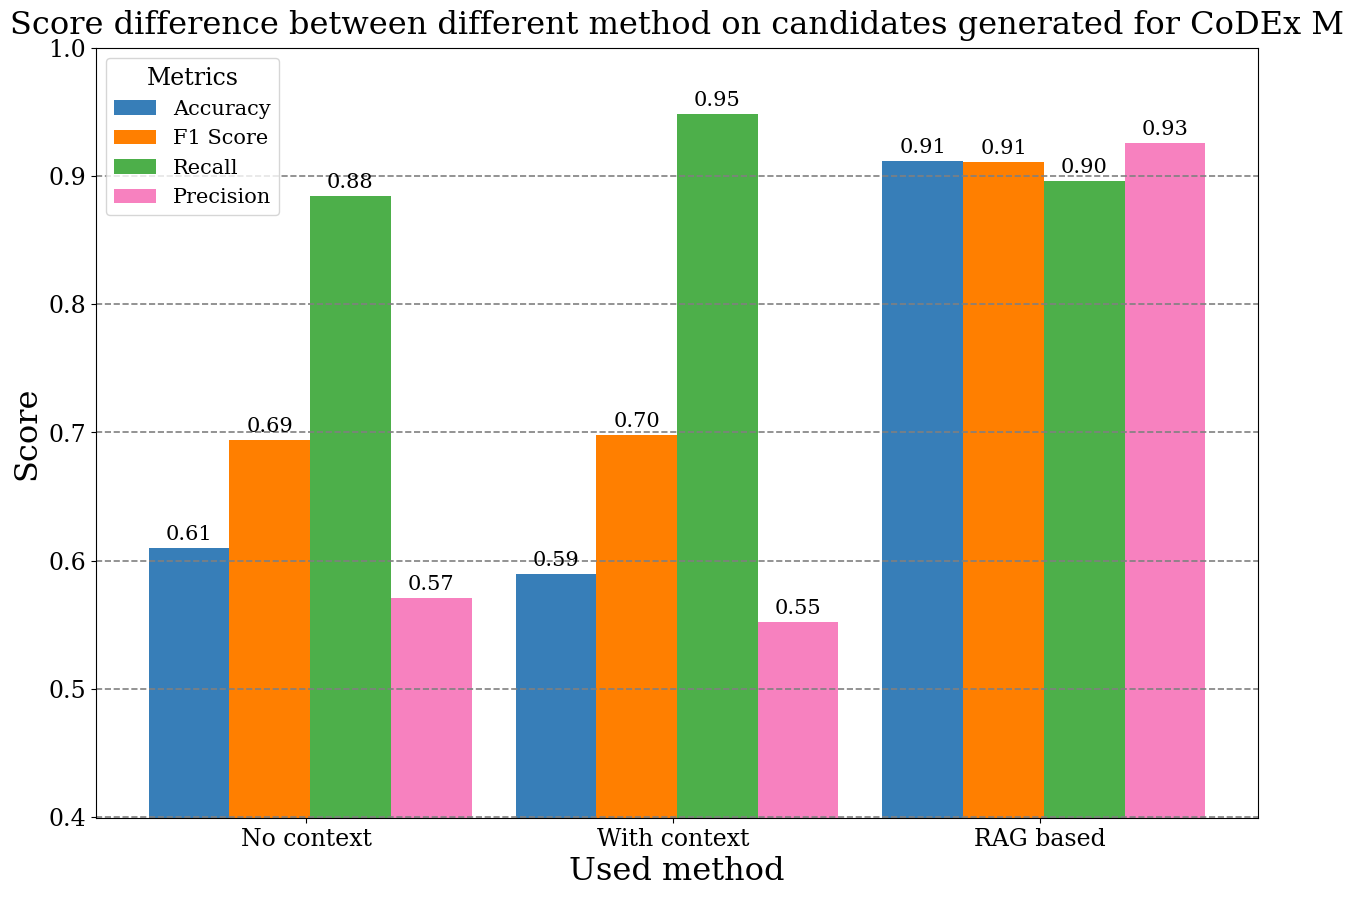

In [37]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np 

# setup family font
plt.rc('font', family='serif',size=17)

plot_dict = model_score_dict.copy()

# get the different scores
accuracy_list = [val[0] for val in plot_dict.values()]
f1_list = [val[1] for val in plot_dict.values()]
recall_list = [val[2] for val in plot_dict.values()]
precision_list = [val[3] for val in plot_dict.values()]

# Create figure and axes
fig, ax = plt.subplots(1,1,figsize=(15, 10))

# set width of bar
# Set position of bar on X axis
barWidth = 0.22
x_acc = np.arange(len(accuracy_list)) 
x_f1 = [x + barWidth for x in x_acc] 
x_recall = [x + barWidth for x in x_f1]
x_prec = [x + barWidth for x in x_recall]

# create the bars
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
bar_acc = plt.bar(x_acc, accuracy_list, color = colors[0], width = barWidth, 
        label ='Accuracy') 
bar_f1 = plt.bar(x_f1, f1_list, color = colors[1], width = barWidth, 
        label ='F1 Score') 
bar_recall = plt.bar(x_recall, recall_list, color = colors[2], width = barWidth, 
        label ='Recall')
bar_prec = plt.bar(x_prec, precision_list, color = colors[3], width = barWidth, 
        label ='Precision') 


# Set axis labels and title
label_fontsize = 23
ax.set_xlabel("Used method", fontsize = label_fontsize)
ax.set_ylabel("Score", fontsize = label_fontsize)
ax.set_title("Score difference between different method on candidates generated for CoDEx M", pad=10, fontsize = label_fontsize)

# Set y-limit to center data
comb_list = accuracy_list + f1_list + recall_list + precision_list
ax.set_ylim(min(comb_list) - np.std(list(comb_list)), min(1,max(comb_list) + np.std(list(comb_list))))

ax.set_xticks([r + 0.10+ barWidth for r in range(len(accuracy_list))], 
        ['No context', 'With context', 'RAG based'])

# Add legend with title
ax.legend(title='Metrics', fontsize = 15, loc=2)


# add bar labels
bar_label_fontsize = 15
ax.bar_label(bar_acc, labels=[f'{v:.2f}' for v in accuracy_list], fontsize=bar_label_fontsize, padding=3)
ax.bar_label(bar_f1, labels=[f'{v:.2f}' for v in f1_list], fontsize=bar_label_fontsize, padding=3)
ax.bar_label(bar_recall, labels=[f'{v:.2f}' for v in recall_list], fontsize=bar_label_fontsize, padding=3)
ax.bar_label(bar_prec, labels=[f'{v:.2f}' for v in precision_list], fontsize=bar_label_fontsize, padding=3)

# Add gridlines (only on the y-axis)
ax.grid(linewidth=1.2, linestyle='--', axis='y', color='grey')
# save figure
plt.savefig('results/codex_m_method.png')
plt.show()

In [33]:
score_dict = {}
top_k_list = [1,2,3,4,5]
for k in top_k_list:
    retriever = vector.as_retriever(search_type="similarity", search_kwargs={"k": k})
    qa = RetrievalQA(
                    combine_documents_chain=combine_documents_chain,
                    verbose=False,
                    retriever=retriever,
                    return_source_documents=False,
                    )
    score_list = eval_sentence_list(qa, sentence_list)
    score_dict[f'top_{k}'] = score_list

In [34]:
def compute_top_k_score(top_k:int, df:pd.DataFrame, score_dict:dict):
    top_k = f'top_{top_k}'
    score_list = score_dict[top_k]
    new_score_list = [extract_score(score) for score in score_list]
    new_score_list = clean_score(new_score_list)
    df['Pred'] = new_score_list
    ground_truth = df['Missing']
    prediction = df['Pred']
    accuracy, f1_score, recall, precision = compute_score(prediction, ground_truth)
    return accuracy, f1_score, recall, precision


In [35]:
top_k_score_dict = {}
top_k_list = [1,2,3,4,5]
for top_k in top_k_list:
    accuracy, f1_score, recall, precision = compute_top_k_score(top_k,filtred_df_sample, score_dict)
    top_k_score_dict[top_k] = accuracy, f1_score, recall, precision 

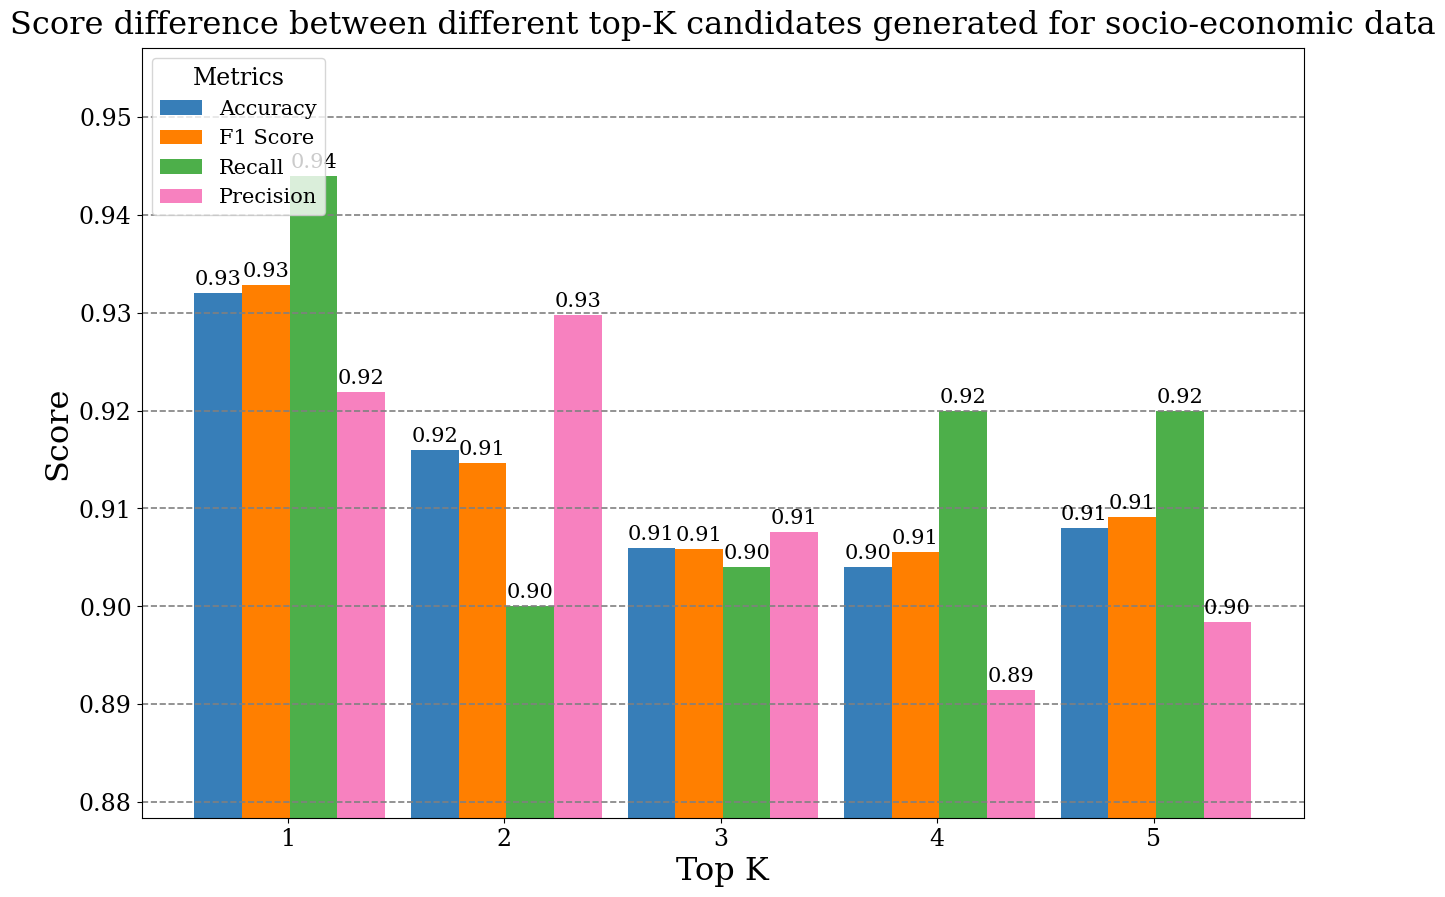

In [36]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np 

# setup family font
plt.rc('font', family='serif',size=17)

plot_dict = top_k_score_dict.copy()

# get the different scores
accuracy_list = [val[0] for val in plot_dict.values()]
f1_list = [val[1] for val in plot_dict.values()]
recall_list = [val[2] for val in plot_dict.values()]
precision_list = [val[3] for val in plot_dict.values()]

# Create figure and axes
fig, ax = plt.subplots(1,1,figsize=(15, 10))

# set width of bar
# Set position of bar on X axis
barWidth = 0.22
x_acc = np.arange(len(accuracy_list)) 
x_f1 = [x + barWidth for x in x_acc] 
x_recall = [x + barWidth for x in x_f1]
x_prec = [x + barWidth for x in x_recall]

# create the bars
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
bar_acc = plt.bar(x_acc, accuracy_list, color = colors[0], width = barWidth, 
        label ='Accuracy') 
bar_f1 = plt.bar(x_f1, f1_list, color = colors[1], width = barWidth, 
        label ='F1 Score') 
bar_recall = plt.bar(x_recall, recall_list, color = colors[2], width = barWidth, 
        label ='Recall')
bar_prec = plt.bar(x_prec, precision_list, color = colors[3], width = barWidth, 
        label ='Precision') 


# Set axis labels and title
label_fontsize = 23
ax.set_xlabel("Top K", fontsize = label_fontsize)
ax.set_ylabel("Score", fontsize = label_fontsize)
ax.set_title("Score difference between different top-K candidates generated for socio-economic data", pad=10, fontsize = label_fontsize)

# Set y-limit to center data
comb_list = accuracy_list + f1_list + recall_list + precision_list
ax.set_ylim(min(comb_list) - np.std(list(comb_list)), min(1,max(comb_list) + np.std(list(comb_list))))

ax.set_xticks([r + 0.10+ barWidth for r in range(len(accuracy_list))], 
        top_k_list)

# Add legend with title
ax.legend(title='Metrics', fontsize = 15, loc=2)


# add bar labels
bar_label_fontsize = 15
ax.bar_label(bar_acc, labels=[f'{v:.2f}' for v in accuracy_list], fontsize=bar_label_fontsize, padding=3)
ax.bar_label(bar_f1, labels=[f'{v:.2f}' for v in f1_list], fontsize=bar_label_fontsize, padding=3)
ax.bar_label(bar_recall, labels=[f'{v:.2f}' for v in recall_list], fontsize=bar_label_fontsize, padding=3)
ax.bar_label(bar_prec, labels=[f'{v:.2f}' for v in precision_list], fontsize=bar_label_fontsize, padding=3)

# Add gridlines (only on the y-axis)
ax.grid(linewidth=1.2, linestyle='--', axis='y', color='grey')
# save figure
#plt.savefig('figures/diff_model_score.png')
plt.show()

In [39]:
df_results = pd.DataFrame.from_dict(model_score_dict, orient='index', columns=['Accuracy','F1 score','Recall','Precision'])
df_results.to_csv('data/codex-m/results.csv')

In [41]:
df_results

,Accuracy,F1 score,Recall,Precision
No context,0.610,0.693878,0.884,0.571059
With context,0.590,0.698085,0.948,0.552448
RAG-based,0.912,0.910569,0.896,0.925620


In [42]:
filtred_df_sample

,Head,Relation,Tail,Missing,distance,Pred,Pred_no_context,Pred_cont
94,Tunisia,diplomatic relation,Malaysia,1,0.664890,1,1,1
472,Hans Blüher,occupation,psychiatrist,0,1.679396,0,1,1
490,Vincent Gallo,occupation,writer,1,0.601883,1,1,1
138,Vladimir Prelog,country of citizenship,Austria-Hungary,1,2.198497,1,0,1
868,Cary Grant,occupation,choreographer,0,1.136022,0,1,1
...,...,...,...,...,...,...,...,...
877,Carlo Emilio Gadda,occupation,politician,1,1.387285,1,0,0
718,Pyotr Yakubovich,genre,poetry,1,2.373903,1,1,1
368,Danny Trejo,occupation,character actor,1,0.907830,1,1,1
899,Rudolph A. Marcus,sibling,Nick Carter,0,2.422619,0,1,1


In [48]:
errors_rows = filtred_df_sample.loc[filtred_df_sample['Missing'] != filtred_df_sample['Pred']]

In [49]:
errors_rows = errors_rows[['Head','Relation','Tail','Missing','Pred','distance']]

In [50]:
errors_rows

,Head,Relation,Tail,Missing,Pred,distance
244,Dashiell Hammett,place of death,Hollywood,0,1,2.333535
261,Bernard Ardura,occupation,essayist,0,1,1.500681
108,Chris Brown,occupation,television actor,1,0,0.571699
336,Ofra Haza,occupation,film actor,1,0,1.152858
917,Moses Hess,occupation,mathematician,0,1,1.311071
246,Hamish Stuart,narrative location,New York City,0,1,2.123267
615,Borys Levytskyi,occupation,scientist,0,1,1.603183
787,Martin Seel,occupation,film producer,0,1,1.931805
175,Buying the Cow,genre,LGBT-related film,1,0,2.081516
862,Sigvart Dagsland,genre,pop music,1,0,2.532465
